## Install

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
project_dir = '/content/gdrive/My Drive/ColabNotebooks/AdvRL/'
import sys
sys.path.insert(0, project_dir)


In [ ]:
!sudo apt-get update && sudo apt-get install libopenmpi-dev

In [ ]:
!pip install mpi4py

In [ ]:
!wget https://raw.githubusercontent.com/ffbskt/AI-General/MCTS_next/ddpg_meta/agents.py -O agents.py
!wget https://raw.githubusercontent.com/ffbskt/AI-General/MCTS_next/ddpg_meta/utils.py -O utils.py
!wget https://raw.githubusercontent.com/ffbskt/AI-General/MCTS_next/ddpg_meta/games.py -O games.py
!wget https://raw.githubusercontent.com/ffbskt/AI-General/MCTS_next/ddpg_meta/nets.py -O nets.py
!wget https://raw.githubusercontent.com/ffbskt/AI-General/MCTS_next/ddpg_meta/replay_buffers.py -O replay_buffers.py

## Test

### Default options
* agent
* env
* ReplayBuffer
* hiro


In [1]:

import gym
from replay_buffers import ReplayBuffer, TransisionWrapper
from nets import MLPActorCritic
from games import BitFlipping2, Env_add_Meta
from utils import MiniLog
from agents import DDPGAgent, HIRO
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import glob, os
# Default options
size=5
env_kw = dict(size=size, rad=1, discret_space=False, seed=0)
env = BitFlipping2(**env_kw)
envf = gym.wrappers.FlattenObservation(gym.wrappers.FilterObservation(env))

agent_kwargs = dict(env=envf, replay_buffer=ReplayBuffer, net=MLPActorCritic, start_steps=2000, update_every=100, iters=None, update_after=1000,
                 repl_size=50000, pi_lr=0.001, q_lr=0.001, batch_size=32, gamma=0.99, polyak=0.995,
                 seed=0, act_noise=0.1, act_limit=None)
hagent_kwargs = agent_kwargs

/home/denis/anaconda3/envs/spinningup/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
def expirement(steps, agent, env, seed=(0, 3), agent_name='agent', model_args={}):
    o = env.reset()
    log = MiniLog(200, kwargs=model_args, save_dir=project_dir + 'data_log',
                  all_log_navigate=project_dir + 'data_log/log_navi')
    print(log.time, end='.csv, ')
    for s in seed:
        agent.reset_agent(s)
        for i in range(steps):

            act = agent.get_action(o)
            o2, r, d, _ = env.step(act)
            log.rput(r, d)
            agent.store(o, act, r, o2, d)
            o = o2
            if d:
                o = env.reset()
        log.pd_append(name=agent_name)
    log.save()
    return log





# a = DDPGAgent(envf, ReplayBuffer, net=MLPActorCritic, start_steps=3000, update_every=50,
#              repl_size=10000)
def test_agent(agent):
    sum_r = 0
    n = 100
    env = BitFlipping2(size, 1, False)
    test_env = gym.wrappers.FlattenObservation(gym.wrappers.FilterObservation(env))
    for j in range(n):
        o, d, ep_len = test_env.reset(), False, 0
        while not (d or (ep_len == 2 ** 7 + 4)):
            # Take deterministic actions at test time (noise_scale=0)
            o, r, d, _ = test_env.step(agent.get_action(o, 0))
            sum_r += r  # TODO bad test for env with unlimit steps
    return sum_r / n


hiro_kwargs = dict(store_delay=20, train_delay=10, step_each=1, ado=None)


In [ ]:
param_grid = dict(store_delay=[500],  train_delay=[100], step_each=[2, 4])

from sklearn.model_selection import ParameterGrid
params = (list(ParameterGrid(param_grid))) 
len(params)

In [ ]:
a = DDPGAgent(**agent_kwargs)
expirement(500, a, envf, model_args={**agent_kwargs})

In [ ]:
hagent_kwargs['act_noise'] = 0
for param in params:
  hiro = HIRO(envf, low_agent_kwargs=agent_kwargs, high_agent_kwargs=hagent_kwargs, **param)
  hiro.low_agent.buffer = TransisionWrapper(ado=[size,] * 3,obs_dim=envf.observation_space.shape[0], act_dim=envf.action_space.shape[0], size=30000)
  expirement(50000, hiro, envf, model_args={**param})
 
  #print(test_agent(hiro))


In [ ]:
env = BitFlipping2(size, 1, False)
test_env = gym.wrappers.FlattenObservation(gym.wrappers.FilterObservation(env))
#a = DDPGAgent(envf, ReplayBuffer, net=MLPActorCritic, start_steps=3000, update_every=50,
#              repl_size=10000)
def test_agent(test_env, agent):
    sum_r = 0
    n = 100
    
    for j in range(n):
        o, d, ep_len = test_env.reset(), False, 0
        while not (d or (ep_len == 2 ** 7+4)):
            # Take deterministic actions at test time (noise_scale=0)
            o, r, d, _ = test_env.step(agent.get_action(o, 0))
            sum_r += r # TODO bad test for env with unlimit steps
    return sum_r / n

%time test_agent(test_env, hiro)

In [ ]:
params

20200612171529.csv


/home/denis/anaconda3/envs/spinningup/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/denis/anaconda3/envs/spinningup/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/denis/anaconda3/envs/spinningup/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequ

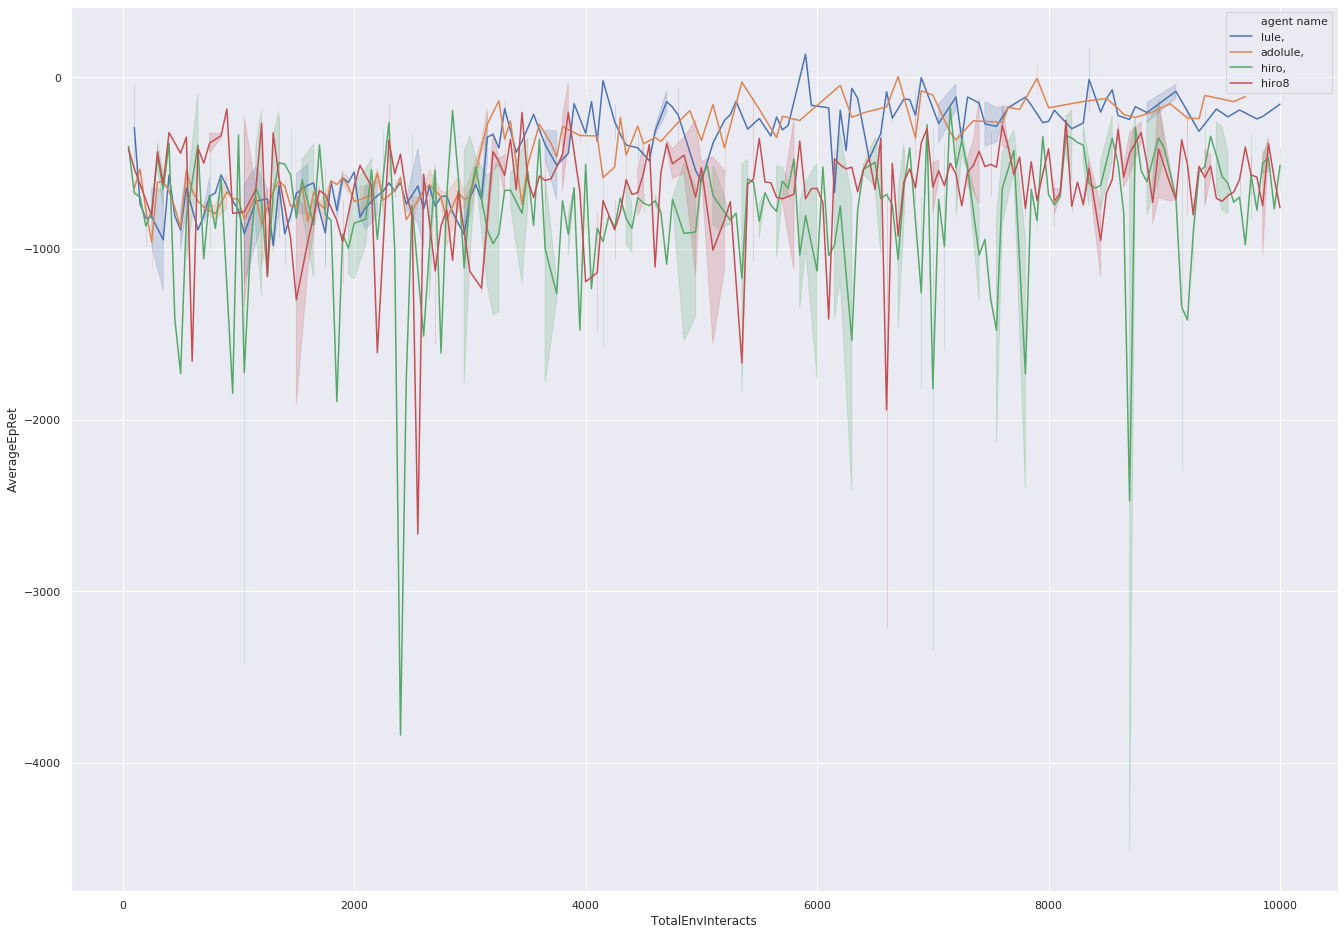

In [4]:
project_dir = './'

DIV_LINE_WIDTH = 10

# Global vars for tracking and labeling data at load time.
os.chdir(project_dir + "data_log")
dt = None
for n, file in zip('lule, adolule, hiro, hiro8'.split(), '20200612171529.csv, 20200612210927.csv, 20200612naivehiroLL.csv, 20200616191719.csv'.split(', ')):#glob.glob("*.csv"):
    if dt is None:

        print(file)
        dt = pd.read_csv(file)
        dt['agent name'] = n # 'a' + str(file[:-4]) #
        #print(dt.head())
    else:
        ndt = pd.read_csv(file)
        ndt['agent name'] = n #'a' + str(file[:-4])
        dt = dt.append(ndt, ignore_index=True)

    #print(dt[dt['TotalEnvInteracts']==50])

sns.set(rc={'figure.figsize':(22.7,16.27)})
sns.lineplot(x='TotalEnvInteracts', y='AverageEpRet',  hue='agent name', data=dt)#, palette=[1])

    #plt.legend()
plt.show()

In [ ]:
!ls

## DDPG from source

In [ ]:
import numpy as np
import scipy.signal

import torch
import torch.nn as nn


def combined_shape(length, shape=None):
    if shape is None:
        return (length,)
    return (length, shape) if np.isscalar(shape) else (length, *shape)

def mlp(sizes, activation, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

def count_vars(module):
    return sum([np.prod(p.shape) for p in module.parameters()])

class MLPActor(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation, act_limit):
        super().__init__()
        pi_sizes = [obs_dim] + list(hidden_sizes) + [act_dim]
        self.pi = mlp(pi_sizes, activation, nn.Tanh)
        self.act_limit = act_limit

    def forward(self, obs):
        # Return output from network scaled to action space limits.
        return self.act_limit * self.pi(obs)

class MLPQFunction(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super().__init__()
        self.q = mlp([obs_dim + act_dim] + list(hidden_sizes) + [1], activation)

    def forward(self, obs, act):
        q = self.q(torch.cat([obs, act], dim=-1))
        return torch.squeeze(q, -1) # Critical to ensure q has right shape.

class MLPActorCritic(nn.Module):

    def __init__(self, observation_space, action_space, hidden_sizes=(256,256),
                 activation=nn.ReLU):
        super().__init__()

        obs_dim = observation_space.shape[0]
        act_dim = action_space.shape[0]
        act_limit = action_space.high[0]

        # build policy and value functions
        self.pi = MLPActor(obs_dim, act_dim, hidden_sizes, activation, act_limit)
        self.q = MLPQFunction(obs_dim, act_dim, hidden_sizes, activation)

    def act(self, obs):
        with torch.no_grad():
            return self.pi(obs).numpy()


In [ ]:
from copy import deepcopy
import numpy as np
import torch
from torch.optim import Adam
import gym
import time
#import spinup.algos.pytorch.ddpg.core as core
#from spinup.utils.logx import EpochLogger


class ReplayBuffer:
    """
    A simple FIFO experience replay buffer for DDPG agents.
    """

    def __init__(self, obs_dim, act_dim, size):
        self.obs_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(combined_shape(size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     obs2=self.obs2_buf[idxs],
                     act=self.act_buf[idxs],
                     rew=self.rew_buf[idxs],
                     done=self.done_buf[idxs])
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in batch.items()}



def ddpg(env_fn, actor_critic=MLPActorCritic, ac_kwargs=dict(), seed=0, 
         steps_per_epoch=4000, epochs=100, replay_size=int(1e6), gamma=0.99, 
         polyak=0.995, pi_lr=1e-3, q_lr=1e-3, batch_size=100, start_steps=10000, 
         update_after=1000, update_every=50, act_noise=0.1, num_test_episodes=10, 
         max_ep_len=1000, logger_kwargs=dict(), save_freq=1, log=None):
    """
    Deep Deterministic Policy Gradient (DDPG)
    Args:
        env_fn : A function which creates a copy of the environment.
            The environment must satisfy the OpenAI Gym API.
        actor_critic: The constructor method for a PyTorch Module with an ``act`` 
            method, a ``pi`` module, and a ``q`` module. The ``act`` method and
            ``pi`` module should accept batches of observations as inputs,
            and ``q`` should accept a batch of observations and a batch of 
            actions as inputs. When called, these should return:
            ===========  ================  ======================================
            Call         Output Shape      Description
            ===========  ================  ======================================
            ``act``      (batch, act_dim)  | Numpy array of actions for each 
                                           | observation.
            ``pi``       (batch, act_dim)  | Tensor containing actions from policy
                                           | given observations.
            ``q``        (batch,)          | Tensor containing the current estimate
                                           | of Q* for the provided observations
                                           | and actions. (Critical: make sure to
                                           | flatten this!)
            ===========  ================  ======================================
        ac_kwargs (dict): Any kwargs appropriate for the ActorCritic object 
            you provided to DDPG.
        seed (int): Seed for random number generators.
        steps_per_epoch (int): Number of steps of interaction (state-action pairs) 
            for the agent and the environment in each epoch.
        epochs (int): Number of epochs to run and train agent.
        replay_size (int): Maximum length of replay buffer.
        gamma (float): Discount factor. (Always between 0 and 1.)
        polyak (float): Interpolation factor in polyak averaging for target 
            networks. Target networks are updated towards main networks 
            according to:
            .. math:: \\theta_{\\text{targ}} \\leftarrow 
                \\rho \\theta_{\\text{targ}} + (1-\\rho) \\theta
            where :math:`\\rho` is polyak. (Always between 0 and 1, usually 
            close to 1.)
        pi_lr (float): Learning rate for policy.
        q_lr (float): Learning rate for Q-networks.
        batch_size (int): Minibatch size for SGD.
        start_steps (int): Number of steps for uniform-random action selection,
            before running real policy. Helps exploration.
        update_after (int): Number of env interactions to collect before
            starting to do gradient descent updates. Ensures replay buffer
            is full enough for useful updates.
        update_every (int): Number of env interactions that should elapse
            between gradient descent updates. Note: Regardless of how long 
            you wait between updates, the ratio of env steps to gradient steps 
            is locked to 1.
        act_noise (float): Stddev for Gaussian exploration noise added to 
            policy at training time. (At test time, no noise is added.)
        num_test_episodes (int): Number of episodes to test the deterministic
            policy at the end of each epoch.
        max_ep_len (int): Maximum length of trajectory / episode / rollout.
        logger_kwargs (dict): Keyword args for EpochLogger.
        save_freq (int): How often (in terms of gap between epochs) to save
            the current policy and value function.
    """

    #logger = EpochLogger(**logger_kwargs)
    #logger.save_config(locals())

    torch.manual_seed(seed)
    np.random.seed(seed)

    env, test_env = env_fn(), env_fn()
    obs_dim = env.observation_space.shape
    act_dim = env.action_space.shape[0]

    # Action limit for clamping: critically, assumes all dimensions share the same bound!
    act_limit = env.action_space.high[0]

    # Create actor-critic module and target networks
    ac = actor_critic(env.observation_space, env.action_space, **ac_kwargs)
    ac_targ = deepcopy(ac)

    # Freeze target networks with respect to optimizers (only update via polyak averaging)
    for p in ac_targ.parameters():
        p.requires_grad = False

    # Experience buffer
    replay_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=replay_size)

    # Count variables (protip: try to get a feel for how different size networks behave!)
    var_counts = tuple(count_vars(module) for module in [ac.pi, ac.q])
    #logger.log('\nNumber of parameters: \t pi: %d, \t q: %d\n'%var_counts)

    # Set up function for computing DDPG Q-loss
    def compute_loss_q(data):
        o, a, r, o2, d = data['obs'], data['act'], data['rew'], data['obs2'], data['done']

        q = ac.q(o,a)

        # Bellman backup for Q function
        with torch.no_grad():
            q_pi_targ = ac_targ.q(o2, ac_targ.pi(o2))
            backup = r + gamma * (1 - d) * q_pi_targ

        # MSE loss against Bellman backup
        loss_q = ((q - backup)**2).mean()

        # Useful info for logging
        loss_info = dict(QVals=q.detach().numpy())

        return loss_q, loss_info

    # Set up function for computing DDPG pi loss
    def compute_loss_pi(data):
        o = data['obs']
        q_pi = ac.q(o, ac.pi(o))
        return -q_pi.mean()

    # Set up optimizers for policy and q-function
    pi_optimizer = Adam(ac.pi.parameters(), lr=pi_lr)
    q_optimizer = Adam(ac.q.parameters(), lr=q_lr)

    # Set up model saving
    #logger.setup_pytorch_saver(ac)

    def update(data):
        # First run one gradient descent step for Q.
        q_optimizer.zero_grad()
        loss_q, loss_info = compute_loss_q(data)
        loss_q.backward()
        q_optimizer.step()

        # Freeze Q-network so you don't waste computational effort 
        # computing gradients for it during the policy learning step.
        for p in ac.q.parameters():
            p.requires_grad = False

        # Next run one gradient descent step for pi.
        pi_optimizer.zero_grad()
        loss_pi = compute_loss_pi(data)
        loss_pi.backward()
        pi_optimizer.step()

        # Unfreeze Q-network so you can optimize it at next DDPG step.
        for p in ac.q.parameters():
            p.requires_grad = True

        # Record things
        #logger.store(LossQ=loss_q.item(), LossPi=loss_pi.item(), **loss_info)

        # Finally, update target networks by polyak averaging.
        with torch.no_grad():
            for p, p_targ in zip(ac.parameters(), ac_targ.parameters()):
                # NB: We use an in-place operations "mul_", "add_" to update target
                # params, as opposed to "mul" and "add", which would make new tensors.
                p_targ.data.mul_(polyak)
                p_targ.data.add_((1 - polyak) * p.data)

    def get_action(o, noise_scale):
        a = ac.act(torch.as_tensor(o, dtype=torch.float32))
        a += noise_scale * np.random.randn(act_dim)
        return np.clip(a, -act_limit, act_limit)

    def test_agent(log):
        for j in range(num_test_episodes):
            o, d, ep_ret, ep_len = test_env.reset(), False, 0, 0
            while not(d or (ep_len == max_ep_len)):
                # Take deterministic actions at test time (noise_scale=0)
                o, r, d, _ = test_env.step(get_action(o, 0))
                ep_ret += r
                ep_len += 1
                log.rput(r, d)
            #logger.store(TestEpRet=ep_ret, TestEpLen=ep_len)

    # Prepare for interaction with environment
    total_steps = steps_per_epoch * epochs
    start_time = time.time()
    o, ep_ret, ep_len = env.reset(), 0, 0

    # Main loop: collect experience in env and update/log each epoch
    for t in range(total_steps):
        
        # Until start_steps have elapsed, randomly sample actions
        # from a uniform distribution for better exploration. Afterwards, 
        # use the learned policy (with some noise, via act_noise). 
        if t > start_steps:
            a = get_action(o, act_noise)
        else:
            a = env.action_space.sample()

        # Step the env
        o2, r, d, _ = env.step(a)
        ep_ret += r
        ep_len += 1
        log.rput(r, d)

        # Ignore the "done" signal if it comes from hitting the time
        # horizon (that is, when it's an artificial terminal signal
        # that isn't based on the agent's state)
        d = False if ep_len==max_ep_len else d

        # Store experience to replay buffer
        replay_buffer.store(o, a, r, o2, d)

        # Super critical, easy to overlook step: make sure to update 
        # most recent observation!
        o = o2

        # End of trajectory handling
        if d or (ep_len == max_ep_len):
            #logger.store(EpRet=ep_ret, EpLen=ep_len)
            o, ep_ret, ep_len = env.reset(), 0, 0

        # Update handling
        if t >= update_after and t % update_every == 0:
            for _ in range(update_every):
                batch = replay_buffer.sample_batch(batch_size)
                update(data=batch)

        # End of epoch handling
        if (t+1) % steps_per_epoch == 0:
            epoch = (t+1) // steps_per_epoch

            # Save model
            #if (epoch % save_freq == 0) or (epoch == epochs):
            #    logger.save_state({'env': env}, None)

            # Test the performance of the deterministic version of the agent.
            
            #test_agent(log)
    log.pd_append(name='sourcetest1')

            # Log info about epoch
    
    log.save()
            



#from spinup.utils.run_utils import setup_logger_kwargs
#logger_kwargs = setup_logger_kwargs(args.exp_name, args.seed)
def make_env():
  env = BitFlipping2(**env_kw)
  envf = gym.wrappers.FlattenObservation(gym.wrappers.FilterObservation(env))
  return envf


log = MiniLog(100, kwargs={}, save_dir=project_dir+'data_log', all_log_navigate=project_dir+'data_log/log_navi')
ddpg(make_env, actor_critic=MLPActorCritic, epochs=400, start_steps=10000, update_after=2000, steps_per_epoch=100, seed=0, log=log)
    #ac_kwargs=dict(hidden_sizes=[args.hid]*args.l), 
    #gamma=args.gamma, seed=args.seed,
    


In [ ]:
log.rplot(), env_kw

# Try to test on other environments

In [5]:
import gym

In [6]:
env = gym.make('LunarLanderContinuous-v2') # if not work reset notebook

/home/denis/anaconda3/envs/spinningup/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [7]:
env.action_space.shape

(2,)

In [8]:
project_dir = ''
class ActionSpace:
    def __init__(self, shape):
        self.shape = [shape]
        self.high = np.ones(shape)

def make_env():
  env =  gym.make('LunarLanderContinuous-v2')
  #env = BitFlipping2(**env_kw)
  envf = gym.wrappers.FlattenObservation(gym.wrappers.FilterObservation(env))
  return envf


log = MiniLog(100, kwargs={}, save_dir=project_dir+'data_log', all_log_navigate=project_dir+'data_log/log_navi')
ddpg(make_env, actor_critic=MLPActorCritic, epochs=400, start_steps=10000, update_after=2000, steps_per_epoch=100, seed=0, log=log)

FileNotFoundError: [Errno 2] No such file or directory: 'data_log/log_navi'

In [ ]:

Box(-100, 100, shape=[env.observation_space.shape[0] * 3]), env.observation_space.shape[0] * 3

In [9]:
# Wrap observation for ado
import numpy as np
import gym.spaces as spaces
from gym import ObservationWrapper
from gym.spaces import Box
from gym.spaces import Discrete



class ADOWrapper(ObservationWrapper):
    r"""Observation wrapper that copy obs to [achivegoal, desiregoal, observation]."""
    def __init__(self, env):
        super(ADOWrapper, self).__init__(env)
        self.observation_space = Box(-100, 100, shape=[env.observation_space.shape[0] * 3])

    def observation(self, observation):
        if isinstance(self.env.observation_space, Box):
            obs = np.asarray(observation, dtype=np.float32).flatten()
        elif isinstance(self.env.observation_space, Discrete):
            obs = np.zeros(space.n, dtype=np.float32)
            obs[observation] = 1.0
            
        return np.hstack([obs, obs, obs])
    


In [10]:
#env = BitFlipping2(**env_kw)
env =  gym.make('LunarLanderContinuous-v2')
env_ado = ADOWrapper(env)
#envf = gym.wrappers.FlattenObservation(gym.wrappers.FilterObservation(env))

agent_kwargs = dict(env=env_ado, replay_buffer=ReplayBuffer, net=MLPActorCritic, start_steps=2000, update_every=100, iters=None, update_after=1000,
                 repl_size=50000, pi_lr=0.001, q_lr=0.001, batch_size=32, gamma=0.99, polyak=0.995,
                 seed=0, act_noise=0.1, act_limit=None)
hagent_kwargs = agent_kwargs

In [14]:
project_dir = ''

def expirement(steps, agent, env, seed=(0), agent_name='agent', model_args={}):
    o = env.reset()
    for i in range(steps):
        act = agent.get_action(o)
        o2, r, d, _ = env.step(act)
        agent.store(o, act, r, o2, d)
        o = o2
        if d:
            o = env.reset()

In [24]:
hagent_kwargs = agent_kwargs
hagent_kwargs['act_shape'] = (8,)
hiro_kwargs = dict(store_delay=200, train_delay=200, step_each=1, ado=[8,8,8])
hiro = HIRO(env_ado, low_agent_kwargs=agent_kwargs, high_agent_kwargs=hagent_kwargs, **hiro_kwargs)
obs = env_ado.reset()

a = DDPGAgent(env_ado, ReplayBuffer, net=MLPActorCritic, start_steps=3000, update_every=50, repl_size=100000)
e = a.get_action(obs)
print(e)

[0.5488135  0.71518937]


In [25]:
expirement(10000, hiro, env_ado, model_args={**agent_kwargs})#, **hagent_kwargs})

In [26]:
lab200 = hiro.low_agent.buffer # store_delay=200, train_delay=200

In [23]:
lab10 = hiro.low_agent.buffer # store_delay=20, train_delay=10

In [22]:
def get_rew(buffer):
    rew = []
    mid_rew = []
    for d, r in zip(buffer.done_buf, buffer.rew_buf):
        mid_rew.append(r)
        if d:
            rew.append(np.mean(mid_rew))
            mid_rew = []
    return rew
        

        
    

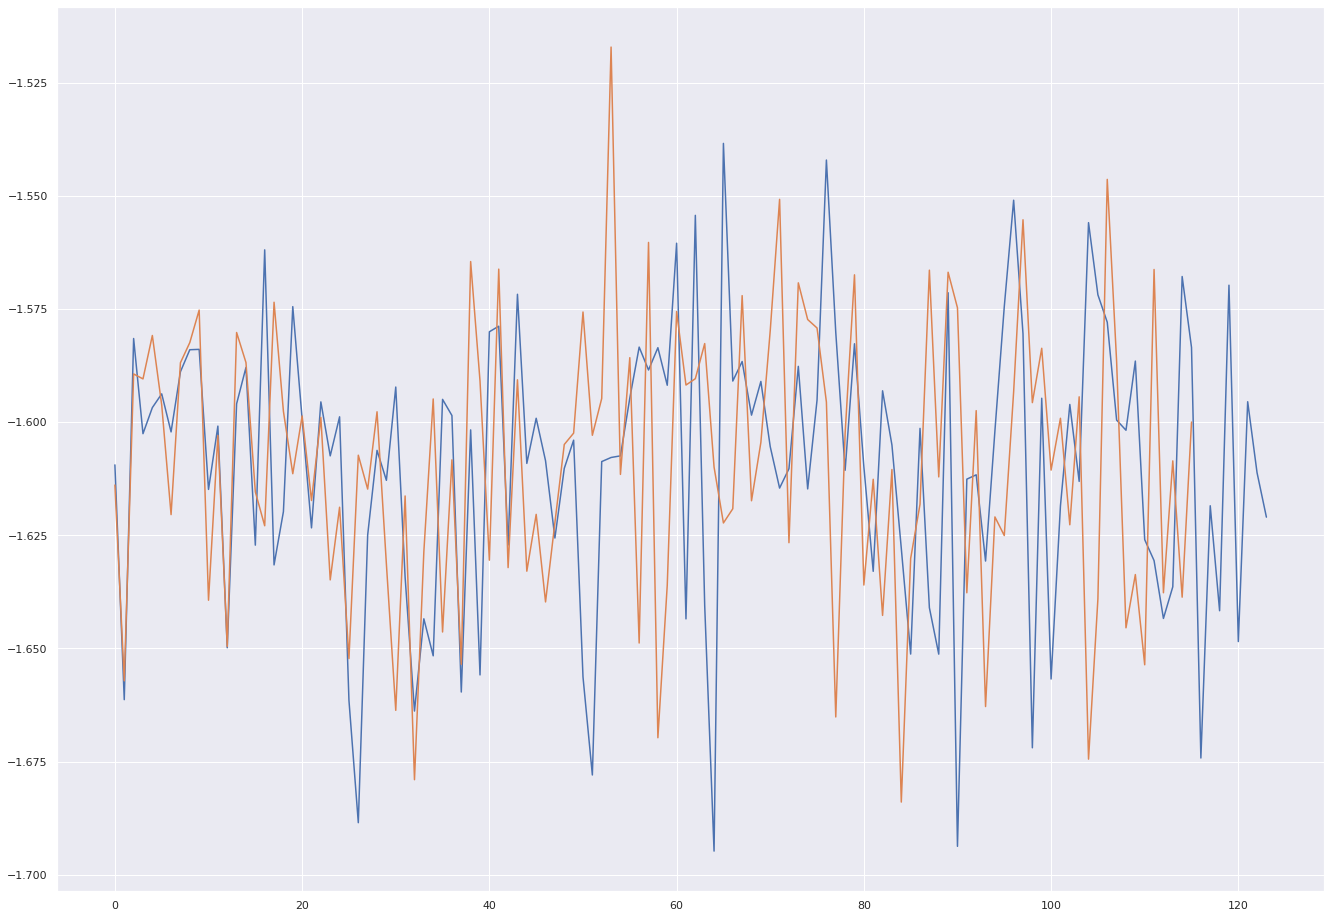

In [27]:
plt.plot(get_rew(lab10))
plt.plot(get_rew(lab200))

     |████████████████████████████████| 6.8 MB 4.4 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=67a10f48e4811beee3a145616b192f7ffdcd9c4140a2a8b571078c5ecf93d7b4
  Stored in directory: /home/denis/.cache/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c
Successfully built sklearn


In [36]:
twobuff = np.vstack([hiro.low_agent.buffer.obs_buf[:, 0:8], hiro.low_agent.buffer.obs_buf[:, 8:16]])

In [39]:
import numpy as np
from sklearn.decomposition import PCA
#X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=2)
X = pca.fit_transform(twobuff)


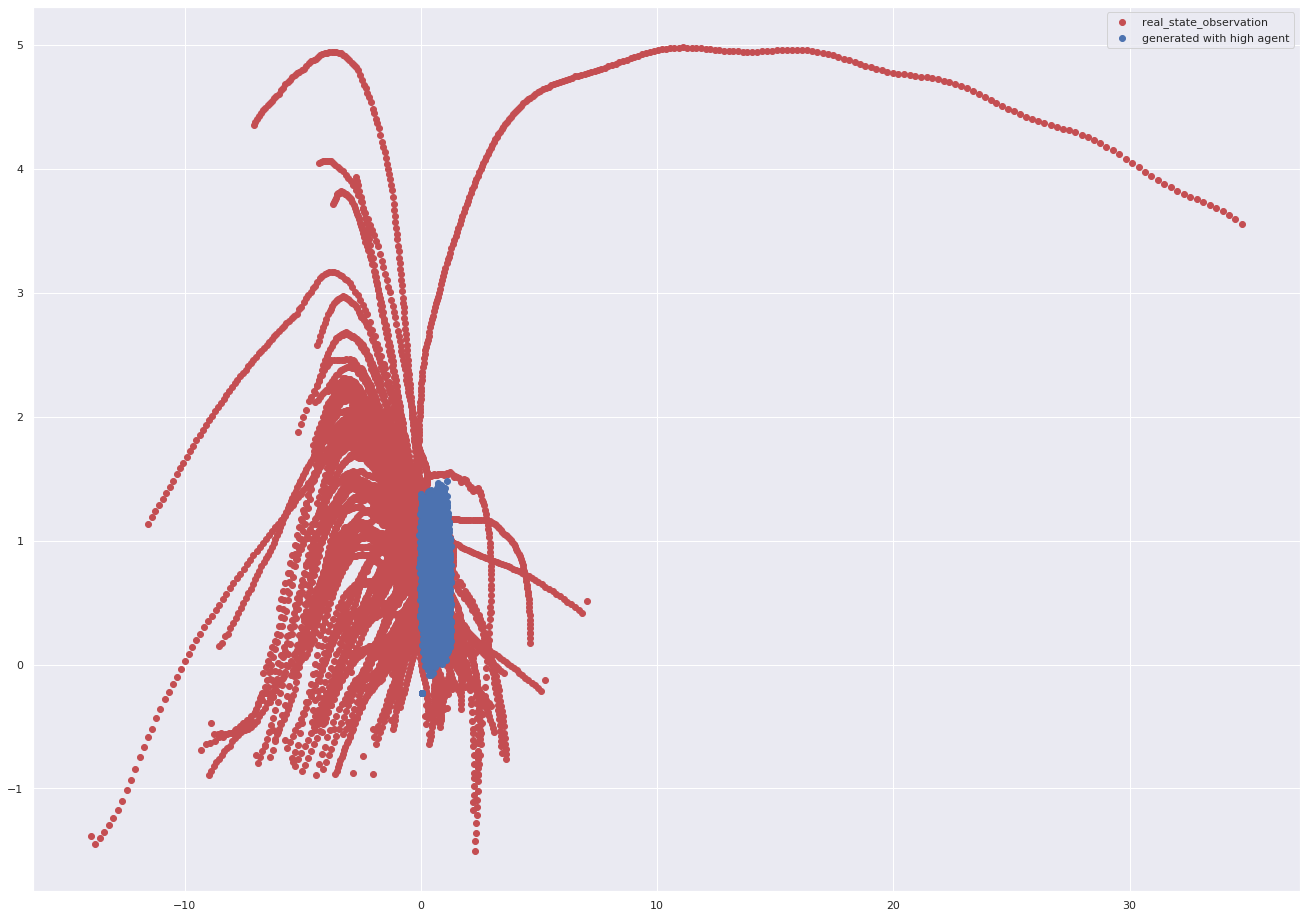

In [47]:
y = np.ones(100000)
y[50001:] = 0
plt.scatter(X[:50001,0], X[:50001,1], c='r', label='real_state_observation')
plt.scatter(X[50001:,0], X[50001:,1], c='b', label='generated with high agent')
plt.legend(loc="best", shadow=False, scatterpoints=1)

In [32]:
hiro.low_agent.buffer.obs_buf[0, 0:8], hiro.low_agent.buffer.obs_buf[0, 8:16], hiro.low_agent.buffer.obs_buf[0, 16:]

(array([ 0.00390968,  1.4085633 ,  0.39599043, -0.10475505, -0.00452355,
        -0.08969773,  0.        ,  0.        ], dtype=float32),
 array([0.60276335, 0.5448832 , 0.4236548 , 0.6458941 , 0.4375872 ,
        0.891773  , 0.96366274, 0.3834415 ], dtype=float32),
 array([ 0.00390968,  1.4085633 ,  0.39599043, -0.10475505, -0.00452355,
        -0.08969773,  0.        ,  0.        ], dtype=float32))

In [ ]:
!ls

In [ ]:
param_grid = dict(store_delay=[500],  train_delay=[100], step_each=[2, 4])

from sklearn.model_selection import ParameterGrid
params = (list(ParameterGrid(param_grid))) 
len(params)

In [ ]:
a = DDPGAgent(**agent_kwargs)
expirement(50000, a, env, model_args={**agent_kwargs})

In [ ]:
dt = None
for n, file in zip('lunrad'.split(), '20200602175524.csv, '.split(', ')):#glob.glob("*.csv"):
    if dt is None:

        print(file)
        dt = pd.read_csv(file)
        dt['agent name'] = n # 'a' + str(file[:-4]) #
        #print(dt.head())
    else:
        ndt = pd.read_csv(file)
        ndt['agent name'] = n #'a' + str(file[:-4])
        dt = dt.append(ndt, ignore_index=True)

    #print(dt[dt['TotalEnvInteracts']==50])

sns.set(rc={'figure.figsize':(22.7,16.27)})
sns.lineplot(x='TotalEnvInteracts', y='AverageEpRet',  hue='agent name', data=dt)#, palette=[1])

    #plt.legend()
plt.show()

## My code environment

In [ ]:
import Enviroment
env = Enviroment.Env(1,1)

In [ ]:
env.obser